In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from colorcloud.cheng2023TransRVNet import TransVRNet, SemanticSegmentationTask
from colorcloud.cheng2023TransRVNet import TransRVNet_loss
from colorcloud.cheng2023TransRVNet import RandomRotationTransform, RandomDroppingPointsTransform, RandomSingInvertingTransform
import lightning as L
import numpy as np
import wandb
from lightning.pytorch.loggers import WandbLogger
from datetime import datetime
import torch
import torchvision
import lightning as L
from lovasz_losses import lovasz_softmax
from boundary_loss import BoundaryLoss
from colorcloud.behley2019iccv import SemanticKITTIDataset, SphericalProjection, ProjectionTransform, ProjectionToTensorTransform, SemanticSegmentationLDM
from torchvision.transforms import v2
from torch.utils.data import DataLoader

/workspace/colorcloud/colorcloud/cheng2023TransRVNet.py:1012: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [3]:
# data_path = '../../data'
# # ds = SemanticKITTIDataset(data_path)
# frame, label, mask = ds[128]

## Setup

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using cuda device


### Convolutions' Parameters

In [5]:
p1 = {
    "b1_in": 1,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}

p2 = {
    "b1_in": 3,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}

## Lightning Training

In [6]:
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    RandomDroppingPointsTransform(),
    RandomRotationTransform(),
    RandomSingInvertingTransform(),
    ProjectionTransform(proj),
    ProjectionToTensorTransform()
])

In [7]:
model = TransVRNet(p1, p2).to(device)
loss_fn = TransRVNet_loss(device)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
data = SemanticSegmentationLDM(proj_kargs={'W': 1024, 'H': 64}, train_batch_size=1, eval_batch_size=1, num_workers=2)
data.setup('fit')
epoch_steps = len(data.train_dataloader())

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [9]:
n_epochs = 1
learner = SemanticSegmentationTask(
    model,
    loss_fn,
    data.viz_tfm, 
    total_steps=n_epochs*epoch_steps
)

In [10]:
# time = datetime.now()
# timestamp = "teste transvrnet " + str(time.year) + '-' + str(time.month) + '-' + str(time.day) + '_' + str(time.hour) + '-' + str(time.minute) + '-' + str(time.second)

# wandb_logger = WandbLogger(project="colorcloud", name=timestamp, log_model="all")
# wandb_logger.watch(learner.model, log="all")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_ma

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

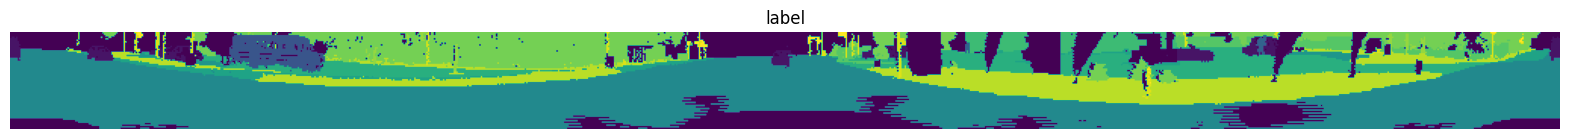

torch.Size([1, 20, 64, 1024])


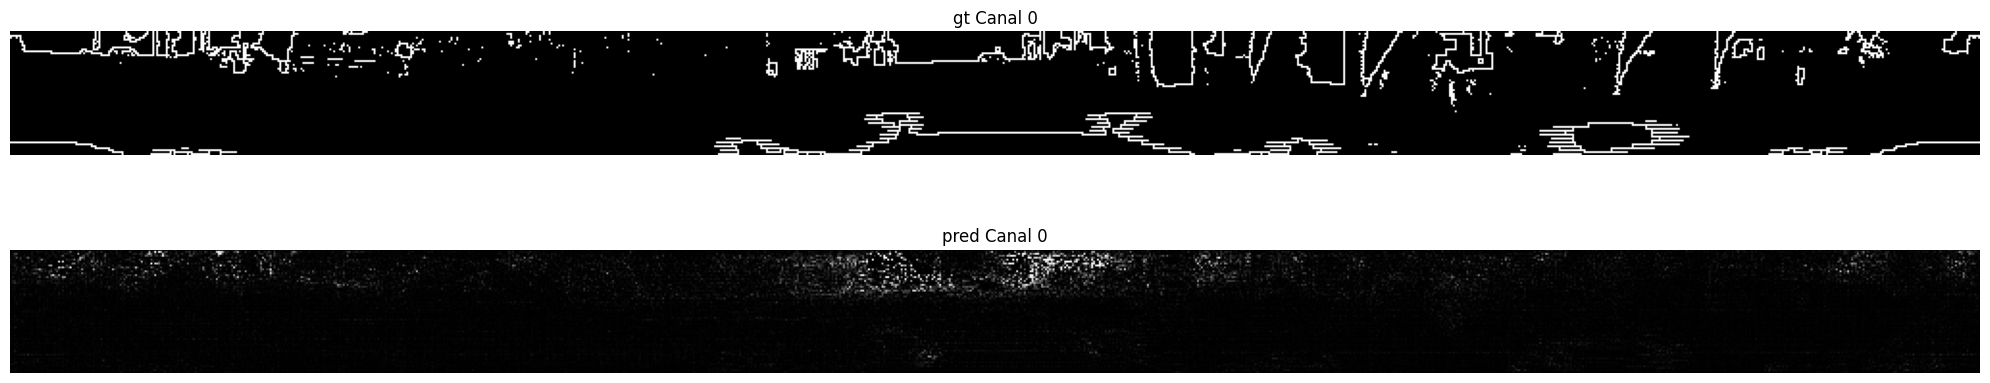

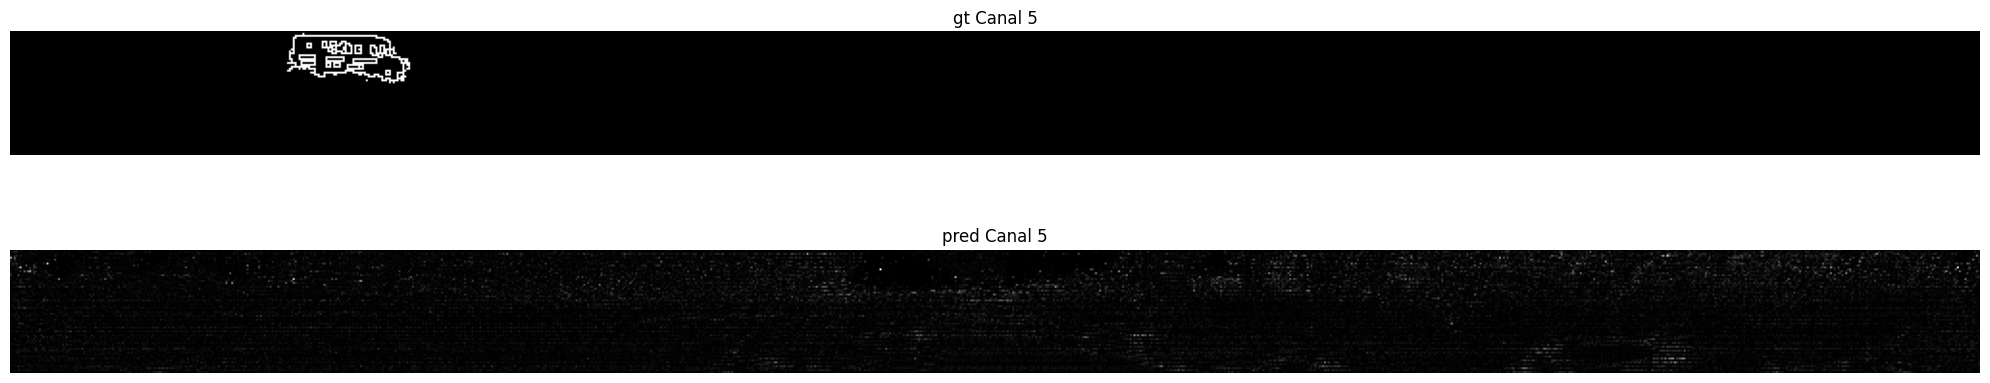

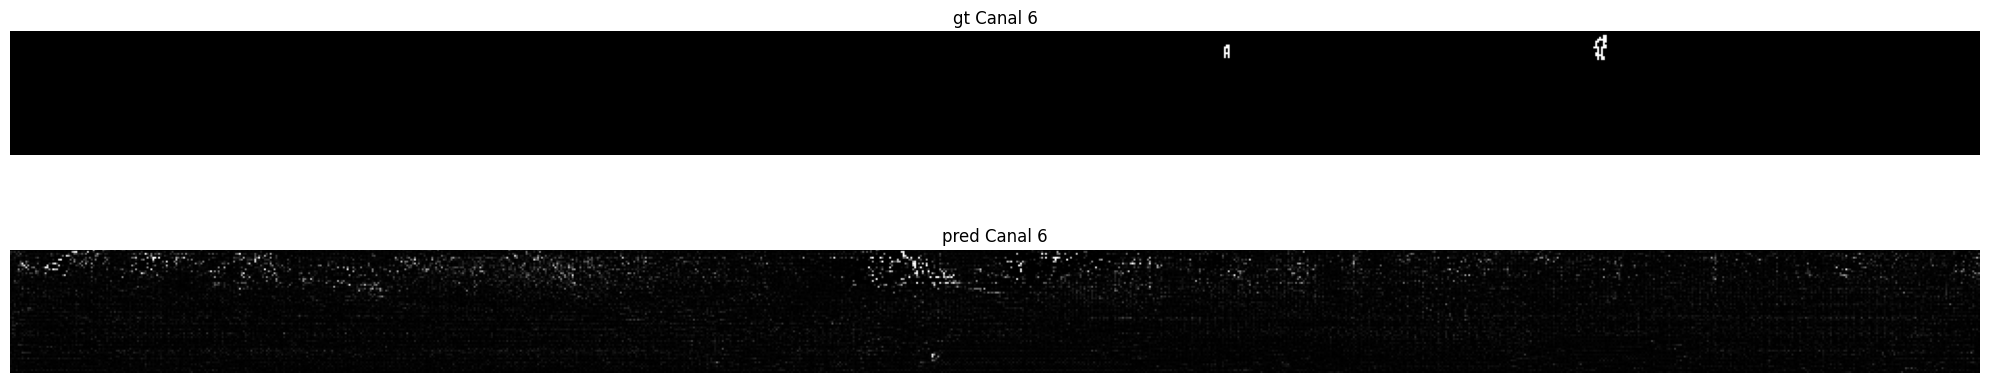

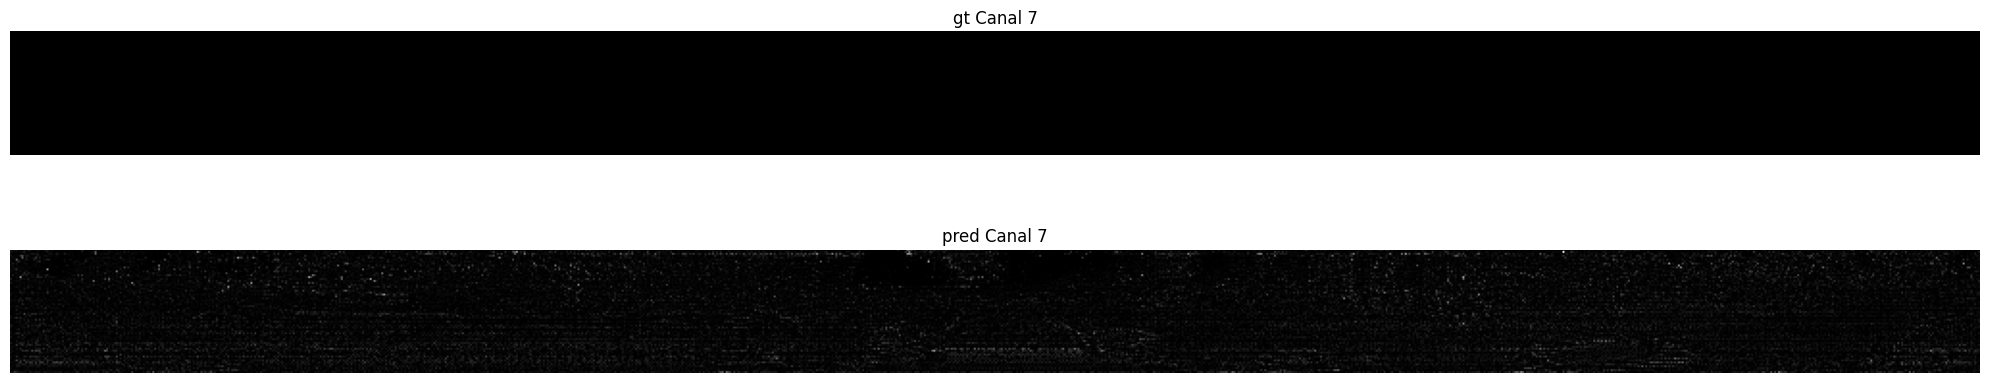

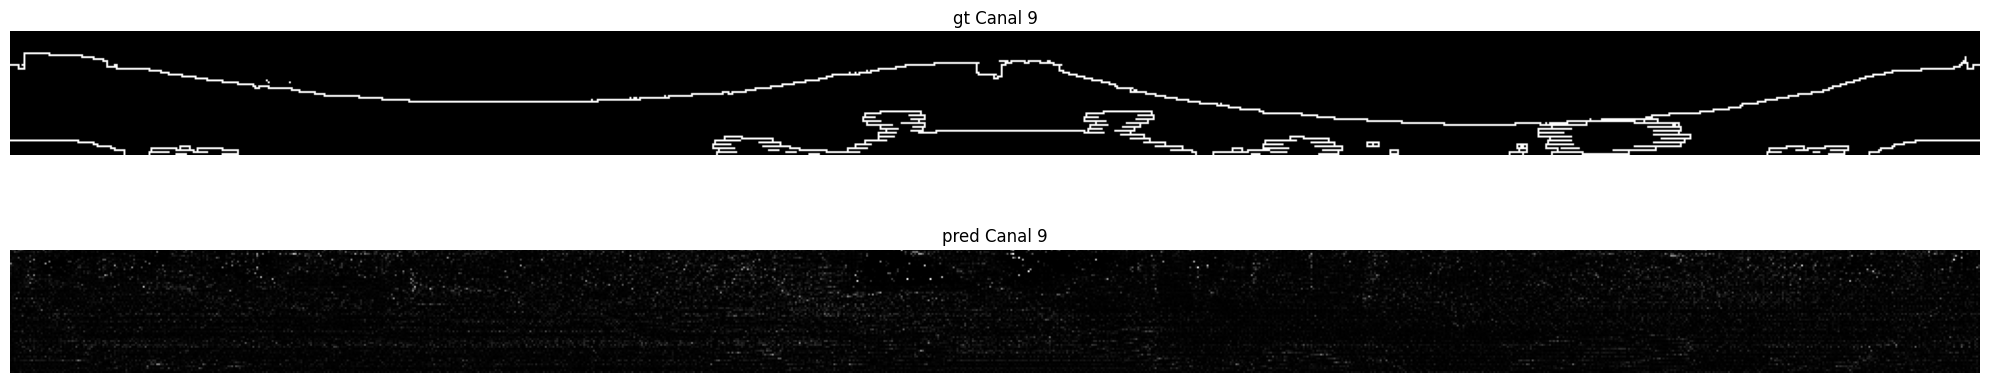

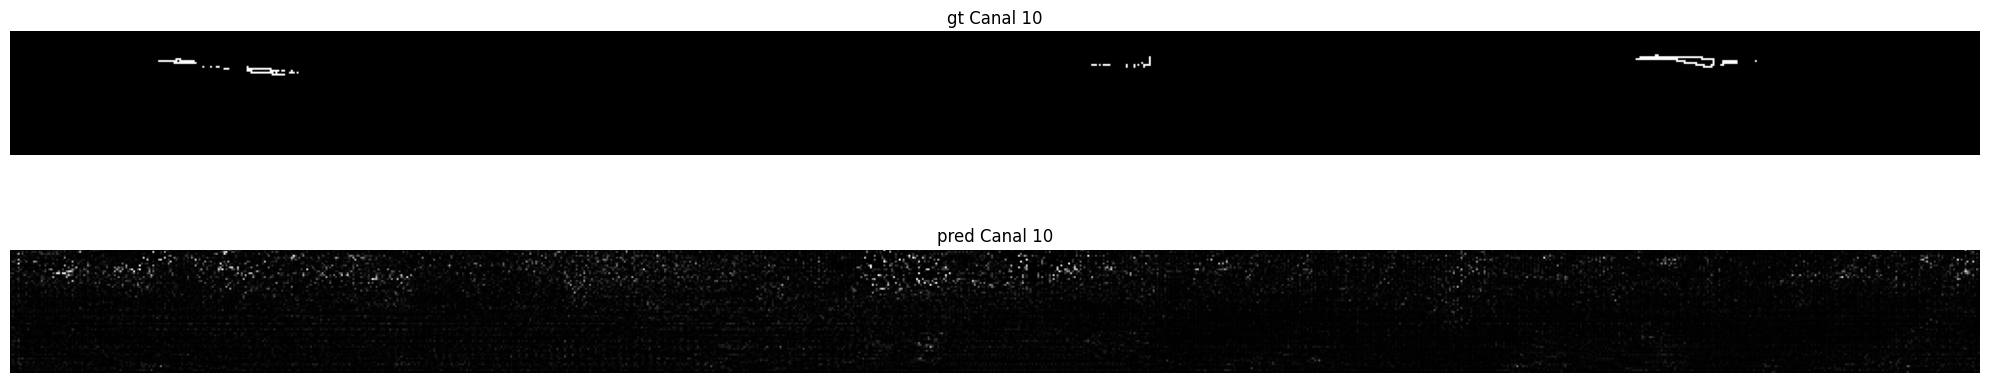

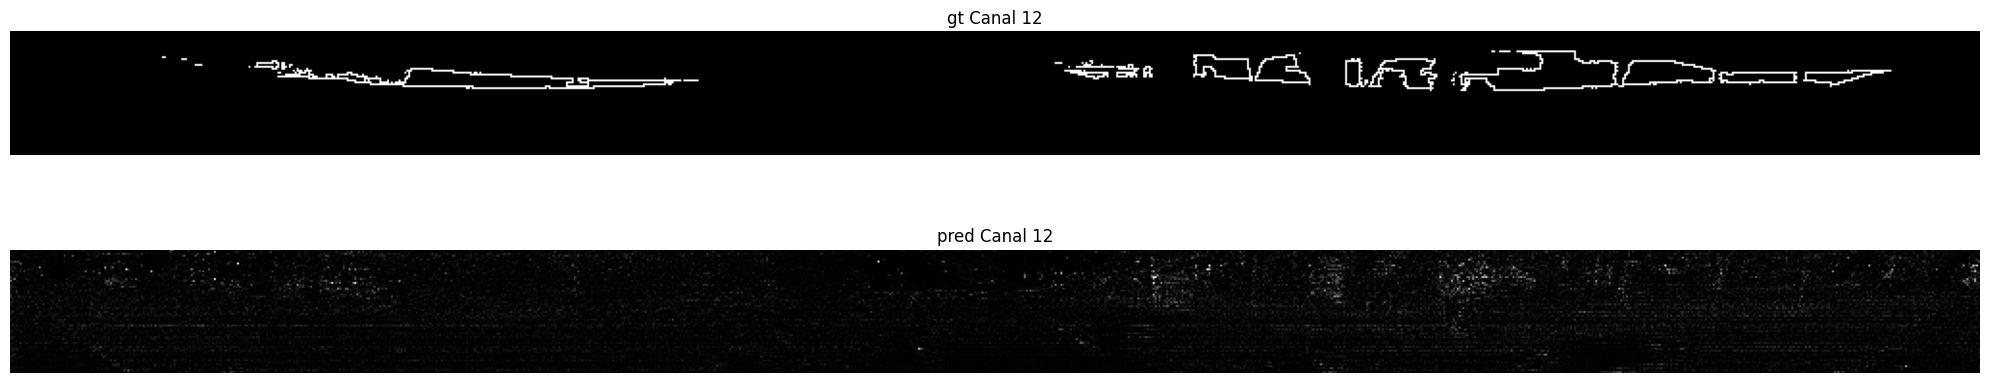

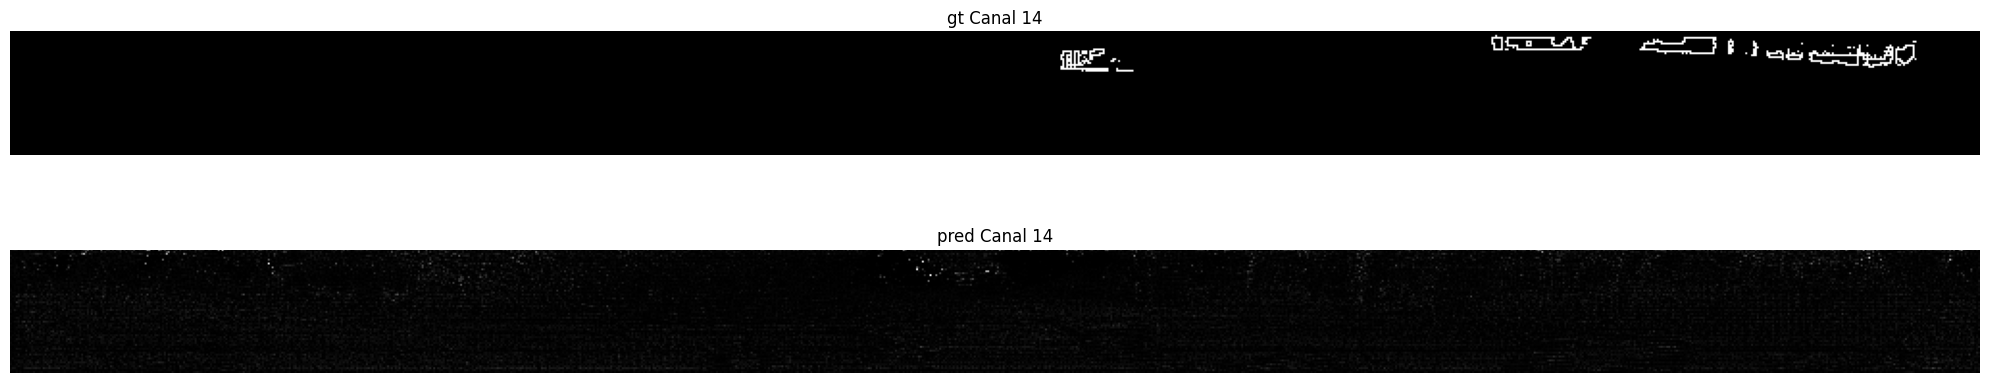

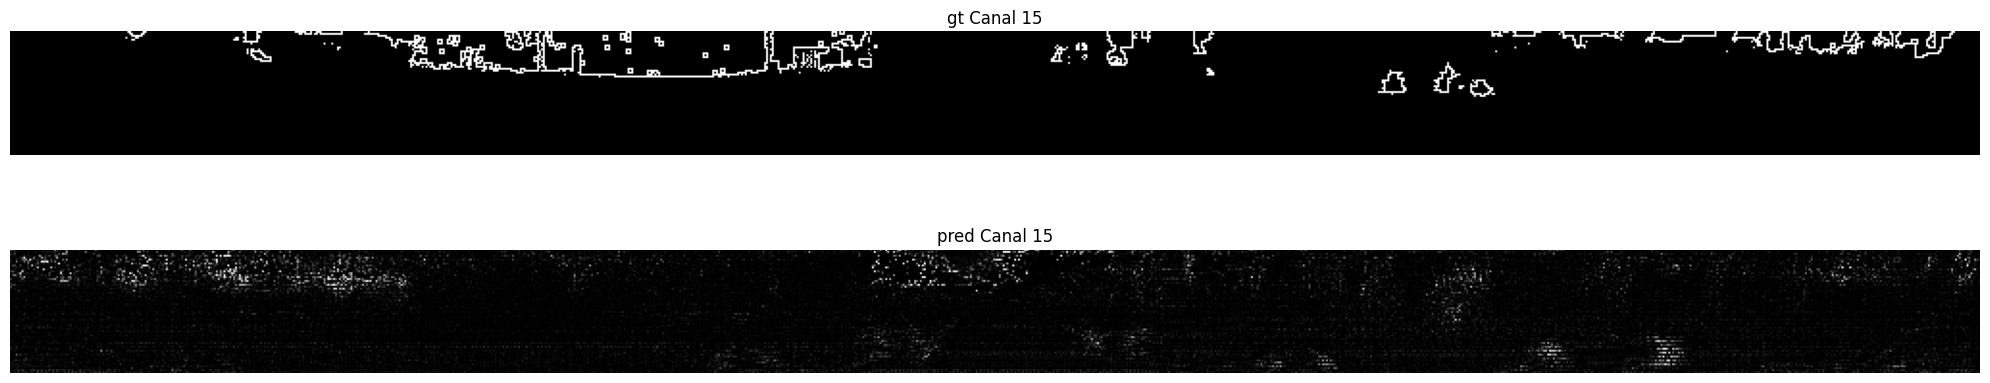

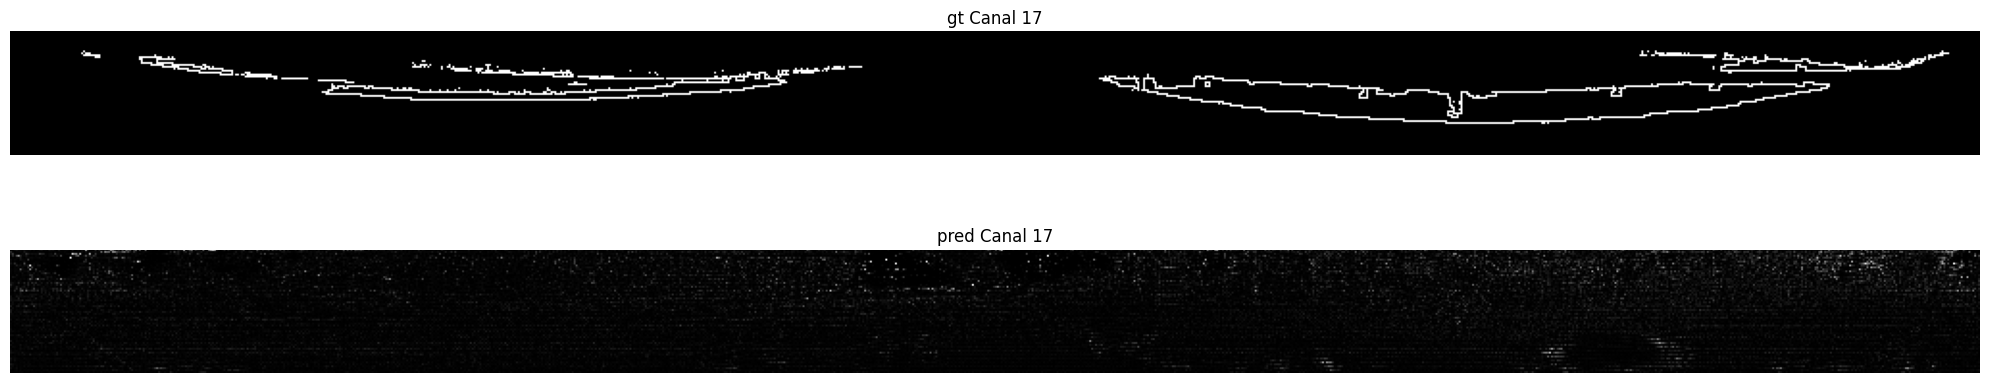

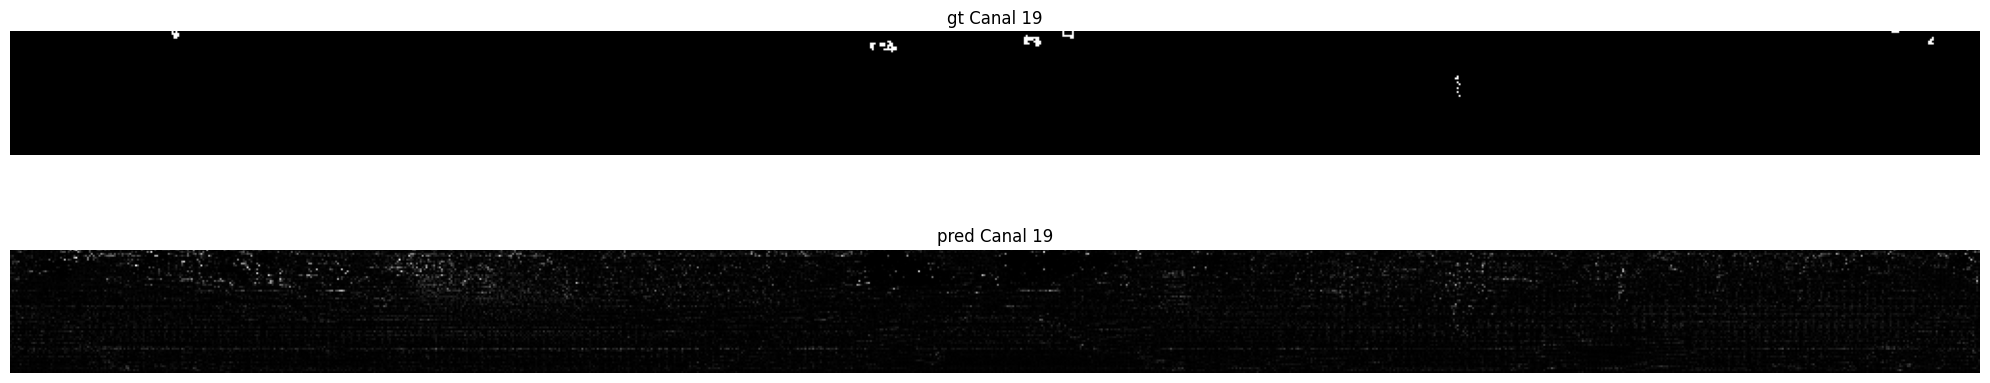

/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/workspace/colorcloud/colorcloud/cheng2023TransRVNet.py:1012: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):
/workspace/colorcloud/colorcloud/cheng2023TransRVNet.py:1012: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):
/workspace/colorcloud/colorcloud/cheng2023TransRVNet.py:1012: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):
/workspace/colorcloud/colorcloud/cheng2023TransRVNet.py

AttributeError: 'ExperimentWriter' object has no attribute 'log'

In [11]:
# train model
trainer = L.Trainer(max_epochs=n_epochs)
trainer.fit(learner, data)